# Data preparation
Run this notebook to prepare the data for modelling. Click **Start Notebook Server** to start a Jupyter notebook kernel and run each cell of this notebook to perform the following steps:
- Download the historical power demand and weather data from blob storage to your local machine.
- Imported the data from csv files and merge the two datasets.
- The data is cleaned by filling gaps in the time series and handling missing values.
- The data is explored through visualisation.
- Features for the forecasting models are computed.
- Data is split into training and test sets.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
import os
from azure.storage.blob import BlockBlobService

### Download data from blob storage

In [2]:
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']

ACCOUNT_NAME = "antaignitedata"
ACCOUNT_KEY = "Vz+e+o/UXGOW2mNF0HWXuXdhzsClHQQuRvSlugOpEfR3raU9rI6KatOkuys8PcTnwpTmwssexBjMIX1464kEoQ=="
CONTAINER_NAME = "antaignitedata"

my_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)
my_service.get_blob_to_path(CONTAINER_NAME, blob_name='nyc_demand.csv', file_path=aml_dir+'nyc_demand.csv')
my_service.get_blob_to_path(CONTAINER_NAME, blob_name='nyc_weather.csv', file_path=aml_dir+'nyc_weather.csv')

Data files saved to disk in:

In [3]:
aml_dir

'C:\\Users\\anta/.azureml/share//antaignite/antaignite/TimeSeriesForecastingTutorial/'

### Load energy demand data and merge with weather data

In [4]:
demand = pd.read_csv(aml_dir + 'nyc_demand.csv', parse_dates=['timeStamp'])
weather = pd.read_csv(aml_dir + 'nyc_weather.csv', parse_dates=['timeStamp'])
demand = pd.merge(demand, weather, on=['timeStamp'], how='outer')
demand.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


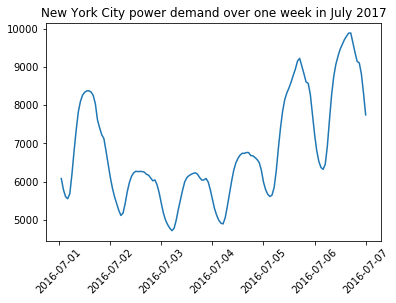

In [5]:
plt_df = demand.loc[(demand.timeStamp>'2016-07-01') & (demand.timeStamp<='2016-07-07')]
plt.plot(plt_df['timeStamp'], plt_df['demand'])
plt.title('New York City power demand over one week in July 2017')
plt.xticks(rotation=45)
plt.show()

### Fill gaps in the time series

Some periods in the time series are missing. This occurs if the period was missing in both the original demand and weather datasets. To identify these gaps, first we create an index of time periods that we would *expect* to be in the time series. There should be one record for every hour between the minimum and maximum datetimes in our dataset.

In [6]:
min_time = min(demand['timeStamp'])
min_time

Timestamp('2012-01-01 00:00:00')

In [7]:
max_time = max(demand['timeStamp'])
max_time

Timestamp('2017-08-12 06:00:00')

In [8]:
dt_idx = pd.date_range(min_time, max_time, freq='H')
dt_idx

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2017-08-11 21:00:00', '2017-08-11 22:00:00',
               '2017-08-11 23:00:00', '2017-08-12 00:00:00',
               '2017-08-12 01:00:00', '2017-08-12 02:00:00',
               '2017-08-12 03:00:00', '2017-08-12 04:00:00',
               '2017-08-12 05:00:00', '2017-08-12 06:00:00'],
              dtype='datetime64[ns]', length=49207, freq='H')

Now we index the dataframe according to this datetime index to insert missing records into the time series:

In [9]:
demand.index = demand['timeStamp']
demand = demand.reindex(dt_idx)

Inserted missing records will have NaN/NaT values for all columns:

In [10]:
demand[demand.isnull().all(axis=1)]

,timeStamp,demand,precip,temp
2016-03-13 02:00:00,NaT,NaN,NaN,NaN
2017-03-12 02:00:00,NaT,NaN,NaN,NaN


Now that there are no missing periods in the time series, we can start handling missing values by filling as many many as possible. Firstly, count the number of missing values in each column:

In [11]:
demand.isnull().sum()

timeStamp      2
demand        83
precip       232
temp         188
dtype: int64

Missing timeStamp can be filled from the dataframe index:

In [12]:
demand.loc[demand.isnull().all(axis=1), 'timeStamp'] = demand.loc[demand.isnull().all(axis=1)].index

For the other columns, we can fill many missing values by interpolating between the two closest non-missing values. Here, we use a quadratic function and set a limit of 6. This limit means that if more than 6 missing values occur consecutively, the missing values are not interpolated over and they remain missing. This is to avoid spurious interpolation between very distant time periods.

In [13]:
demand = demand.interpolate(limit=6, method='quadratic')

Fill missing precip values with most likely value of 0:

In [14]:
demand['precip'] = demand['precip'].fillna(0)

In [15]:
demand.isnull().sum()

timeStamp     0
demand       49
precip        0
temp         86
dtype: int64

The number of missing values has now been greatly reduced. Records containing the remaining missing values will be removed later after model features have been created.

### Explore the data

By visualising the data, we can gain some intuition as to what kind of features could be helpful to the model.

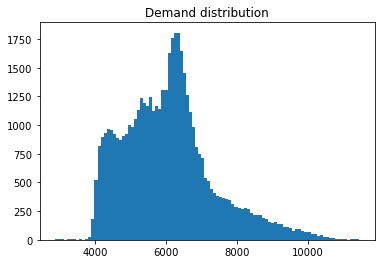

In [16]:
plt.hist(demand['demand'].dropna(), bins=100)
plt.title('Demand distribution')
plt.show()

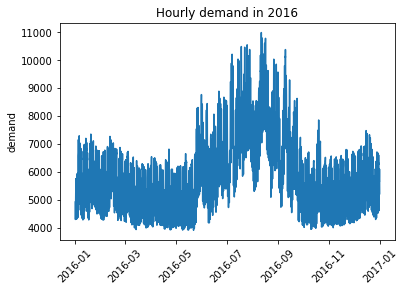

In [17]:
plt_df = demand.copy().loc[(demand['timeStamp']>='2016-01-01') & (demand['timeStamp']<'2017-01-01'), ]
plt.plot(plt_df['timeStamp'], plt_df['demand'], markersize=1)
plt.title('Hourly demand in 2016')
plt.ylabel('demand')
plt.xticks(rotation=45)
plt.show()

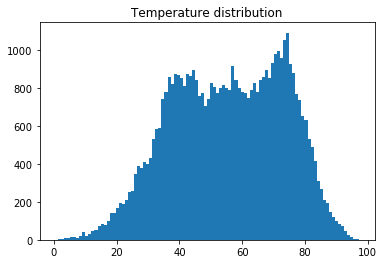

In [18]:
plt.hist(demand['temp'].dropna(), bins=100)
plt.title('Temperature distribution')
plt.show()

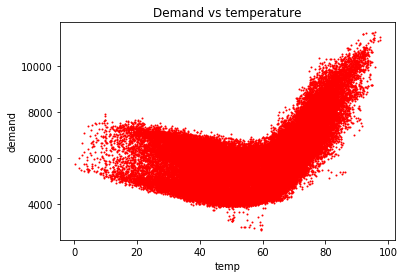

In [19]:
plt.plot(demand['temp'], demand['demand'], 'ro', markersize=1)
plt.title('Demand vs temperature')
plt.xlabel('temp')
plt.ylabel('demand')
plt.show()

The autocorrelation plot below shows the extent to which the demand variable correlates with itself at different intervals (lags). It is clear from this plot that demand is highly autocorrelated over the closest 6 hour period.

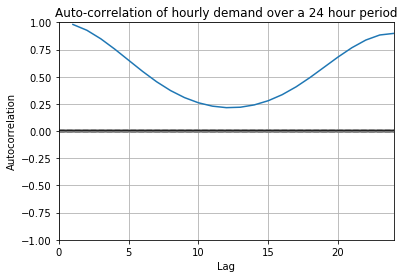

In [20]:
autocorrelation_plot(demand['demand'].dropna())
plt.xlim(0,24)
plt.title('Auto-correlation of hourly demand over a 24 hour period')
plt.show()

### Compute features for forecasting models

After exploring the data, it is clear that the energy demand follows seasonal trends, with daily, weekly and annual periodicity. We will create features that encode this information. First, we compute time driven features based on timeStamp. Note for dayofweek, Monday=0 and Sunday=6.

In [21]:
demand_features = demand.copy()

In [22]:
demand_features['hour'] = demand_features.timeStamp.dt.hour
demand_features['month'] = demand_features.timeStamp.dt.month-1
demand_features['dayofweek'] = demand_features.timeStamp.dt.dayofweek

Compute lagged demand features

In [23]:
for i in [1,2,3,4,5,6,12,24]:
    demand_features['demand_lag'+str(i)] = demand_features['demand'].shift(i, freq='1H')

Compute rolling means of demand and temp.

In [24]:
demand_features['demand_rmean_day'] = demand_features['demand'].rolling(window=24, min_periods=1).mean().shift(1, freq='1H')
demand_features['demand_rmean_wk'] = demand_features['demand'].rolling(window=24*7, min_periods=24).mean().shift(1, freq='1H')
demand_features['temp_rmean_day'] = demand_features['temp'].rolling(window=24, min_periods=1).mean().shift(1, freq='1H')
demand_features['temp_rmean_wk'] = demand_features['temp'].rolling(window=24*7, min_periods=24).mean().shift(1, freq='1H')

In [25]:
demand_features.head()

,timeStamp,demand,precip,temp,hour,month,dayofweek,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag12,demand_lag24,demand_rmean_day,demand_rmean_wk,temp_rmean_day,temp_rmean_wk
2012-01-01 00:00:00,2012-01-01 00:00:00,4937.5,0.0,46.13,0,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,2012-01-01 01:00:00,4752.1,0.0,45.89,1,0,6,4937.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4937.500000,NaN,46.130000,NaN
2012-01-01 02:00:00,2012-01-01 02:00:00,4542.6,0.0,45.04,2,0,6,4752.1,4937.5,NaN,NaN,NaN,NaN,NaN,NaN,4844.800000,NaN,46.010000,NaN
2012-01-01 03:00:00,2012-01-01 03:00:00,4357.7,0.0,45.03,3,0,6,4542.6,4752.1,4937.5,NaN,NaN,NaN,NaN,NaN,4744.066667,NaN,45.686667,NaN
2012-01-01 04:00:00,2012-01-01 04:00:00,4275.5,0.0,42.61,4,0,6,4357.7,4542.6,4752.1,4937.5,NaN,NaN,NaN,NaN,4647.475000,NaN,45.522500,NaN


### Final data cleaning and write out training and test datasets

Count remaining null values.

In [26]:
demand_features.isnull().sum()

timeStamp            0
demand              49
precip               0
temp                86
hour                 0
month                0
dayofweek            0
demand_lag1         49
demand_lag2         49
demand_lag3         49
demand_lag4         49
demand_lag5         49
demand_lag6         49
demand_lag12        49
demand_lag24        49
demand_rmean_day    26
demand_rmean_wk     24
temp_rmean_day      22
temp_rmean_wk       24
dtype: int64

Count number of rows with any null values

In [27]:
demand_features.loc[demand_features.isnull().any(axis=1), ].shape[0]

161

This is a very small proportion of the overall dataset so can be safely dropped.

In [28]:
demand_features.dropna(how='any', inplace=True)

Split data into training and test datasets. All data after 1st July 2016 is reserved for the test set.

In [29]:
train, test = (demand_features.loc[demand_features['timeStamp']<'2016-07-01'], demand_features.loc[demand_features['timeStamp']>='2016-07-01'])
train.to_csv(aml_dir + 'nyc_demand_train.csv', float_format='%.4f', index=False)
test.to_csv(aml_dir + 'nyc_demand_test.csv', float_format='%.4f', index=False)